Linear regression models are a good starting point for regression tasks. Such models are popular because they can be fit very quickly, and are very interpretable. You are probably familiar with the simplest form of a linear regression model (i.e., fitting a straight line to data) but such models can be extended to model more complicated data behavior.

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#### Simple Linear Regression
We will start with the most familiar linear regression, a straight-line fit to data. A straight-line fit is a model of the form:
$$
y = ax +b
$$
where $a$ is commonly known as the slope, and $b$ is commonly known as the intercept.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5.

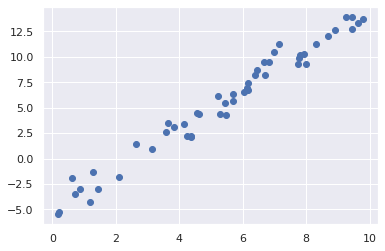

In [2]:
rng = np.random.RandomState(0)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's LinearRegression estimator to fit this data and construct the best-fit line.

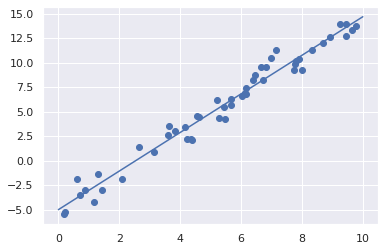

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore. Here the relevant parameters are `coef_` and `intercept_`:

In [4]:
print("Model Slope:", model.coef_)
print("Model Intercept:", model.intercept_)

Model Slope: [1.96927329]
Model Intercept: -5.0072100841302785


We see that the results are very close to the inputs, as we might hope.

The `LinearRegression` estimator is much more capable than this, however in addition to simple straight-line fits, it can also handle multidimensional linear models of the form.
$$
y = a_0 +a_1x_1 + a_2x_2+...
$$

Where $x$ there are multiple  values. Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [5]:
rng = np.random.RandomState(0)
X = 10 * rng.rand(100,4) # training feature
y = 0.5 + np.dot(X, [1.5,-2,1,0.5]) #training label

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X,y)
print(model.intercept_)
print(model.coef_)

0.4999999999999911
[ 1.5 -2.   1.   0.5]


Here the $y$  data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single `LinearRegression` estimator to fit lines, planes, or hyperplanes to our data. It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

**Basis Function Regression**

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to basis functions. The idea is to take our multidimensional linear model:
$$
y = a_0 + a_1x_1 + a_2x_2 + a_3x_3 + ...
$$
and build the $ x_1, x_2, x_3$ and so on, from our single-dimensional input $x$. That is, we let  $x_n = f_n(x) $, where $ f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$ , our model becomes a polynomial regression:
$$
y = a_0 + a_1x + a_2x^2 + a_3x^3 + ...
$$
Notice that this is still a linear model, the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other. What we have effectively done is taken our one-dimensional  values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

**Polynomial basis functions**

This polynomial projection is useful enough that it is built into Scikit-Learn, using the `PolynomialFeatures` transformer:

In [6]:
from sklearn.preprocessing import PolynomialFeatures

x = np.array([2,3,4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, np.newaxis])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value. This new, higher-dimensional data representation can then be plugged into a linear regression.

Let's make a `7th-degree` polynomial model using a pipeline.

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$ . For example, here is a sine wave with noise:

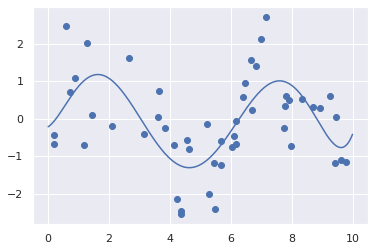

In [11]:
rng = np.random.RandomState(0)
x = 10 * rng.rand(50)
y = np.sin(x) + rng.randn(50)
xfit = np.linspace(0,10,1000)
poly_model = poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:,np.newaxis])

plt.scatter(x,y)
plt.plot(xfit, yfit);

Our linear model, through the use of `7th-order` polynomial basis functions, can provide an excellent fit to this non-linear data!

**Gaussian basis functions**

Of course, other basis functions are possible. For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases. The result might look something like the following figure:

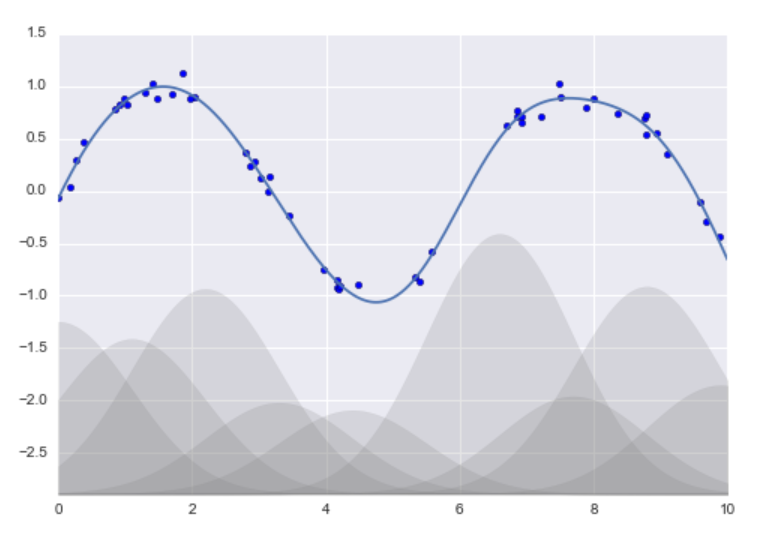

The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data. These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them, as shown here and illustrated in the following figure (Scikit-Learn transformers are implemented as Python classes; reading Scikit-Learn's source is a good way to see how they can be created).

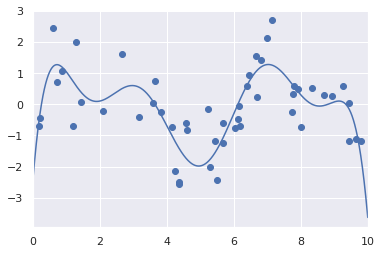

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(8),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

#### Regularization
The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting. For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good.

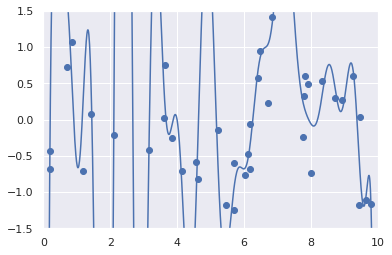

In [14]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())

model.fit(x[:, np.newaxis], y)
y_pred = model.predict(xfit[:, np.newaxis])
plt.scatter(x,y)
plt.plot(xfit, y_pred)

plt.xlim(0,10)
plt.ylim(-1.5, 1.5);

With the data projected to the `30-dimensional basis`, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data. We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations.

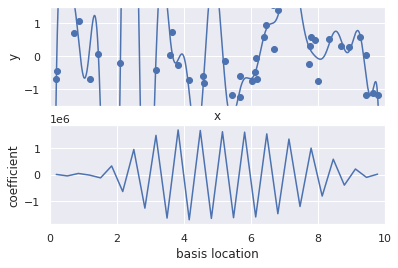

In [15]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

The lower panel of this figure shows the amplitude of the basis function at each location. This is typical over-fitting behavior when basis functions overlap. The coefficients of adjacent basis functions blow up and cancel each other out. We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters. Such a penalty is known as `regularization`, and comes in several forms.

**Ridge regression ( $L_2$ Regularization)**

The most common form of regularization is known as ridge regression or 
regularization, sometimes also called `Tikhonov regularization`. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients. In this case, the penalty on the model fit would be
$$
P = \alpha \sum_{n=1}^{N} \theta_n ^2
$$

where $\alpha$  is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the `Ridge` estimator:

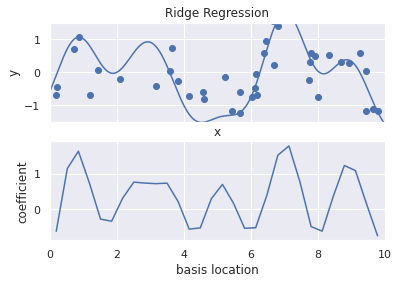

In [16]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

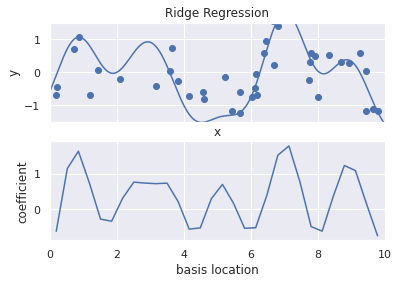

In [18]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model. In the limit $\alpha → 0 $ , we recover the standard linear regression result. In the limit $\alpha → ∞$, all model responses will be suppressed. One advantage of ridge regression in particular is that it can be computed very efficiently at hardly more computational cost than the original linear regression model.

#### Lasso regression ($ L_1$ regularization)
Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients.
$$
P = \alpha \sum_{n=1}^{N} |\theta_n|
$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.442e-02, tolerance: 7.297e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


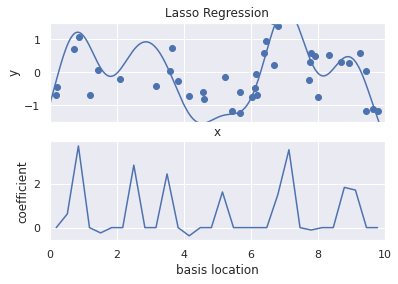

In [19]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions. As with ridge regularization, the  parameter $\alpha$ tunes the strength of the penalty, and should be determined via, for example, cross-validation